# Finding the right model

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score

from xgboost import XGBClassifier
from xgboost import plot_importance

from imblearn.over_sampling import SMOTE

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.functions import load_OU_data, CourseScaler, plot_confusion, score_grid, \
smotecourses, process_courses, course_cross_validate, Course_GridSearchCV, \
model_evaluate_presentation, cross_val_presentation, GridSearchPresentationCV

import pickle

import warnings

from IPython.display import display

warnings.filterwarnings("ignore")
sns.set_style('white')
pd.set_option('display.max_columns',None)

In [3]:
df_full = load_OU_data(prediction_window=.5)

In [4]:
df = df_full.copy()
df = df.drop(columns = ['id_student','region','highest_education', \
                   'imd_band','gender','age_band','disability','studied_credits',
                   'module_presentation_length','date_registration'])
df['final_result'] = np.array(['No Intervention' if w in ['Pass','Distinction'] \
              else 'Needs Intervention' for w in df['final_result']])
test_df = df[df['code_presentation'] == '2014J']
train_df = df[df['code_presentation'] != '2014J']

X_train = train_df.drop(columns = ['final_result','code_presentation'])
y_train = train_df['final_result']
X_test = test_df.drop(columns = ['final_result','code_presentation'])
y_test = test_df['final_result']

X_train_transformed, y_train_transformed, X_test_transformed \
                                = process_courses(X_train, y_train, X_test)

# FSM

0.7870333639883041

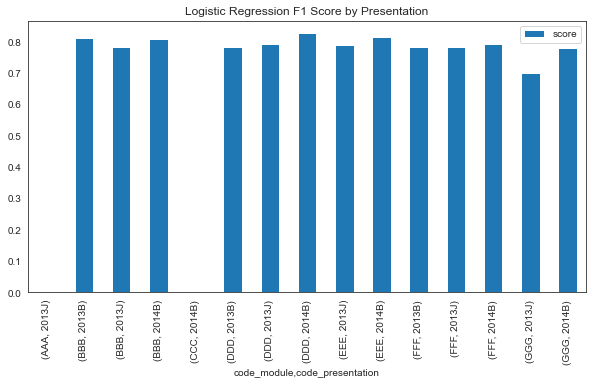

score
code_module code_presentation          
AAA         2013J                   NaN
BBB         2013B              0.809978
            2013J              0.780488
            2014B              0.808637
CCC         2014B                   NaN
DDD         2013B              0.782471
            2013J              0.790948
            2014B              0.825059
EEE         2013J              0.789731
            2014B              0.812155
FFF         2013B              0.780666
            2013J              0.781568
            2014B              0.792948
GGG         2013J              0.699008
            2014B              0.777778

0.7404791929382093
                    precision    recall  f1-score   support

Needs Intervention       0.61      0.68      0.64      2735
   No Intervention       0.82      0.77      0.80      5195

          accuracy                           0.74      7930
         macro avg       0.72      0.73      0.72      7930
      weighted avg       0.75      0.74      0.74      7930



In [5]:
model = LogisticRegression()
scores = cross_val_presentation(model, train_df, scoring = 'accuracy', verbose = 1)
scores.plot(kind = 'bar', figsize = (10,5), title = 'Logistic Regression F1 Score by Presentation')
plt.show()
display(scores)
y_pred = model.predict(X_test_transformed)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

## GridsearchCV for best logistic regression hyperparameters

trying:
{'C': 0.001, 'penalty': 'none', 'random_state': 111, 'solver': 'lbfgs'}
average score:  0.7870886248194271
trying:
{'C': 0.001, 'penalty': 'none', 'random_state': 111, 'solver': 'sag'}
average score:  0.7871537586694889
trying:
{'C': 0.001, 'penalty': 'none', 'random_state': 111, 'solver': 'saga'}
average score:  0.7871537586694889
trying:
{'C': 0.001, 'penalty': 'none', 'random_state': 111, 'solver': 'newton-cg'}
average score:  0.7871537586694889
trying:
{'C': 0.01, 'penalty': 'none', 'random_state': 111, 'solver': 'lbfgs'}
average score:  0.7870886248194271
trying:
{'C': 0.01, 'penalty': 'none', 'random_state': 111, 'solver': 'sag'}
average score:  0.7871537586694889
trying:
{'C': 0.01, 'penalty': 'none', 'random_state': 111, 'solver': 'saga'}
average score:  0.7871537586694889
trying:
{'C': 0.01, 'penalty': 'none', 'random_state': 111, 'solver': 'newton-cg'}
average score:  0.7871537586694889
trying:
{'C': 0.1, 'penalty': 'none', 'random_state': 111, 'solver': 'lbfgs'}
aver

score
code_module code_presentation          
AAA         2013J                   NaN
BBB         2013B              0.809978
            2013J              0.791196
            2014B              0.812024
CCC         2014B                   NaN
DDD         2013B              0.768743
            2013J              0.788075
            2014B              0.815603
EEE         2013J              0.782396
            2014B              0.848987
FFF         2013B              0.781478
            2013J              0.781568
            2014B              0.796564
GGG         2013J              0.701213
            2014B               0.81137

cross validated accuracy score:
0.7914764962798563
validation accuracy: 
0.7406052963430012
validation set confusion matrix


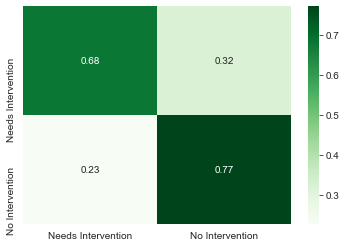

In [6]:
LRparams = [{'solver': ['lbfgs','sag','saga','newton-cg'],
         'penalty': ['none'],
         'random_state':[111],
          'C':[.001,.01,.1]},
          {'solver': ['lbfgs','sag','saga','newton-cg','liblinear'],
         'penalty': ['l2'],
         'random_state':[111],
          'C':[.001,.01,.1]},
          {'solver':['saga'],
          'penalty':['elasticnet'], 'l1_ratio':[.4,.7,.9]},
          {'solver':['saga','liblinear'],
          'penalty':['l1'],
          'C':[.001,.01,.1]}]


LRgrid = GridSearchPresentationCV(LogisticRegression(), LRparams,
                                scoring='accuracy', verbose = 1)

LRgrid.fit(train_df)
LRmodel = score_grid(LRgrid, X_test_transformed, y_test)
pickle.dump(LRmodel,open('../models/LRmodel3.pkl','wb'))

## Logistic Regression Evaluation
By optimizing the hyperparameters of the logistic regression model, which are all regularization parameters, we've barely moved the needle at all.  We gained .0002 accuracy.

# More model types
We used the logistic regression classifier to tune our features, but now it's time to try some other models.  We will use Course_GridsearchCV to optimize the hyperparameters for these as well.

# Decision Tree
A decision tree is a promising candidate for this problem because it does not assume the independence of the features. Instead it seeks to find the best way to divide and subdivide the data in a tree structure based on the values of different variables.  We can tune how many features each split is allowed to consider.  Once the tree is build predictions are made by sending an observations down the tree sending it on a path to the predicted class as it reaches each split in the tree is sent in one or the other direction.  You can think of it like a deterministic Pachinko machine!

trying:
{'criterion': 'entropy', 'max_depth': 4, 'max_features': 4, 'min_samples_split': 0.5, 'random_state': 111, 'splitter': 'best'}
average score:  0.7642471171317629
trying:
{'criterion': 'entropy', 'max_depth': 4, 'max_features': 4, 'min_samples_split': 0.6, 'random_state': 111, 'splitter': 'best'}
average score:  0.7642471171317629
trying:
{'criterion': 'entropy', 'max_depth': 4, 'max_features': 5, 'min_samples_split': 0.5, 'random_state': 111, 'splitter': 'best'}
average score:  0.7757951561758097
trying:
{'criterion': 'entropy', 'max_depth': 4, 'max_features': 5, 'min_samples_split': 0.6, 'random_state': 111, 'splitter': 'best'}
average score:  0.7757951561758097
trying:
{'criterion': 'entropy', 'max_depth': 20, 'max_features': 4, 'min_samples_split': 0.5, 'random_state': 111, 'splitter': 'best'}
average score:  0.7642471171317629
trying:
{'criterion': 'entropy', 'max_depth': 20, 'max_features': 4, 'min_samples_split': 0.6, 'random_state': 111, 'splitter': 'best'}
average score

score
code_module code_presentation          
AAA         2013J                   NaN
BBB         2013B                0.7865
            2013J              0.766211
            2014B              0.745131
CCC         2014B                   NaN
DDD         2013B               0.80359
            2013J              0.791667
            2014B              0.794326
EEE         2013J              0.823961
            2014B              0.771639
FFF         2013B              0.800975
            2013J               0.77678
            2014B              0.792043
GGG         2013J              0.693495
            2014B              0.739018

cross validated accuracy score:
0.7757951561758097
validation accuracy: 
0.7253467843631778
validation set confusion matrix


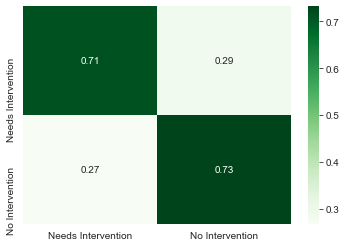

In [7]:
DTparams = {'criterion':['entropy'],
           'splitter':['best'],
           'max_depth':[4,20],'min_samples_split':[.5,.6],
           'max_features':[4,5],'random_state':[111]}


DTgrid = GridSearchPresentationCV(DecisionTreeClassifier(), DTparams,
                                scoring='accuracy', verbose = 1)

DTgrid.fit(train_df)
DTmodel = score_grid(DTgrid, X_test_transformed, y_test)
pickle.dump(DTmodel,open('../models/DTmodel3.pkl','wb'))

### Decision Tree Evaluation 
As expected, this model is better at predicting how a student will do.  It doesn't rely on establishing a straight line through the data to model it, which is probably not the best approach in this problem space.  We see a nice increase in accuracy here.

# Random Forest Classifier
This is an interesting extension to the decision tree model.  It creates a whole forest of decision trees and trains each one on a subset of the data and a subset of the features.  This is a technique called bagging, or [Boostrap AGGregation](https://machinelearningmastery.com/bagging-and-random-forest-ensemble-algorithms-for-machine-learning/) (check the link for more on this).  It works on the principle that a bunch of bad predictors, on average will be more accurate than one good predictor.  This worked for Francis Galton in [guessing the weight of an ox](https://crowdsourcingweek.com/blog/using-the-crowd-to-predict/), maybe it will work here!

trying:
{'criterion': 'entropy', 'max_depth': 4, 'max_samples': 0.7, 'min_samples_split': 0.1, 'n_estimators': 150}
average score:  0.7814574060399397
trying:
{'criterion': 'entropy', 'max_depth': 4, 'max_samples': 0.7, 'min_samples_split': 0.1, 'n_estimators': 200}
average score:  0.7825448807114502
trying:
{'criterion': 'entropy', 'max_depth': 4, 'max_samples': 0.7, 'min_samples_split': 0.3, 'n_estimators': 150}
average score:  0.773973851962928
trying:
{'criterion': 'entropy', 'max_depth': 4, 'max_samples': 0.7, 'min_samples_split': 0.3, 'n_estimators': 200}
average score:  0.7705220431228281
trying:
{'criterion': 'entropy', 'max_depth': 4, 'max_samples': None, 'min_samples_split': 0.1, 'n_estimators': 150}
average score:  0.7869489235651188
trying:
{'criterion': 'entropy', 'max_depth': 4, 'max_samples': None, 'min_samples_split': 0.1, 'n_estimators': 200}
average score:  0.786279947947604
trying:
{'criterion': 'entropy', 'max_depth': 4, 'max_samples': None, 'min_samples_split': 0.3

score
code_module code_presentation          
AAA         2013J                   NaN
BBB         2013B              0.804842
            2013J              0.760857
            2014B              0.776461
CCC         2014B                   NaN
DDD         2013B              0.790919
            2013J              0.782328
            2014B              0.813239
EEE         2013J              0.810513
            2014B              0.821363
FFF         2013B              0.793664
            2013J              0.795332
            2014B              0.790235
GGG         2013J              0.708931
            2014B              0.781654

cross validated accuracy score:
0.7869489235651188
validation accuracy: 
0.7269861286254728
validation set confusion matrix


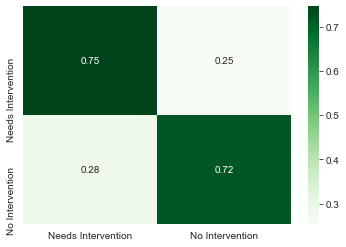

In [8]:
RFparams = {'n_estimators':[150,200],
           'criterion':['entropy'],
           'max_depth':[4,7],
           'min_samples_split':[.1,.3],
           'max_samples':[.7,None]}
           
RFgrid = GridSearchPresentationCV(RandomForestClassifier(n_jobs = -1,
                                                        random_state=111), 
                                  RFparams, scoring = 'accuracy', verbose = 1)

RFgrid.fit(train_df)

RFmodel = score_grid(RFgrid, X_test_transformed, y_test)
pickle.dump(RFmodel, open('../models/RFmodel3.pkl','wb'))

### Random Forest Classifier Evaluation:
Apparently bagging is not the right approach to this problem.  Our single well tuned decision tree outperformed the random forest classifier.  I guess the wisdom of the crowd is not always superior to the wisdom of the expert!

# eXtreme Gradient Boost model:
XGBoost models have gained a lot of popularity recently and won a lot of Kaggle competitions.  It uses another popular idea called [boosting](https://en.wikipedia.org/wiki/Gradient_boosting).  That's a pretty involved wikipedia article, but the TLDR is that it's a similar ensemble method like random forest, but whereas random forest trains a bunch of trees in parallel and takes the aggregate of their predictions, boosting stacks the trees on top of each other and each one tries to improve on the one below it by predicting where the previous one made mistakes.  I think of it as like a line of morons each grading the next one's paper, which is an analysis of the previous one's paper.  Each one gets a lot wrong, but something right so the right answers percolate through and some of the wrong answers get corrected at each step.

trying:
{'base_score': 0.4, 'colsample_bytree': 0.7, 'eval_metric': 'logloss', 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 400, 'num_parallel_tree': 3, 'subsample': 0.5}
average score:  0.7911727375735815
trying:
{'base_score': 0.4, 'colsample_bytree': 0.7, 'eval_metric': 'logloss', 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 400, 'num_parallel_tree': 3, 'subsample': 0.7}
average score:  0.7927651004421473
trying:
{'base_score': 0.4, 'colsample_bytree': 0.7, 'eval_metric': 'logloss', 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 400, 'num_parallel_tree': 4, 'subsample': 0.5}
average score:  0.7911094907309091
trying:
{'base_score': 0.4, 'colsample_bytree': 0.7, 'eval_metric': 'logloss', 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 400, 'num_parallel_tree': 4, 'subsample': 0.7}
average score:  0.7925209492707292
trying:
{'base_score': 0.4, 'colsample_bytre

average score:  0.7783123904940807
trying:
{'base_score': 0.4, 'colsample_bytree': 0.7, 'eval_metric': 'logloss', 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 400, 'num_parallel_tree': 4, 'subsample': 0.7}
average score:  0.7800405866184951
trying:
{'base_score': 0.4, 'colsample_bytree': 0.7, 'eval_metric': 'logloss', 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 750, 'num_parallel_tree': 3, 'subsample': 0.5}
average score:  0.7759084611185684
trying:
{'base_score': 0.4, 'colsample_bytree': 0.7, 'eval_metric': 'logloss', 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 750, 'num_parallel_tree': 3, 'subsample': 0.7}
average score:  0.77661813450143
trying:
{'base_score': 0.4, 'colsample_bytree': 0.7, 'eval_metric': 'logloss', 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 750, 'num_parallel_tree': 4, 'subsample': 0.5}
average score:  0.7762056999807486
trying:
{'base_

average score:  0.789243245700921
trying:
{'base_score': 0.4, 'colsample_bytree': 0.8, 'eval_metric': 'logloss', 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 750, 'num_parallel_tree': 4, 'subsample': 0.5}
average score:  0.7893984321553836
trying:
{'base_score': 0.4, 'colsample_bytree': 0.8, 'eval_metric': 'logloss', 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 750, 'num_parallel_tree': 4, 'subsample': 0.7}
average score:  0.7890650486253061
trying:
{'base_score': 0.4, 'colsample_bytree': 0.8, 'eval_metric': 'logloss', 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 400, 'num_parallel_tree': 3, 'subsample': 0.5}
average score:  0.7906254805674717
trying:
{'base_score': 0.4, 'colsample_bytree': 0.8, 'eval_metric': 'logloss', 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 400, 'num_parallel_tree': 3, 'subsample': 0.7}
average score:  0.7924356478268647
trying:
{'

average score:  0.7770818144692306
trying:
{'base_score': 0.4, 'colsample_bytree': 0.8, 'eval_metric': 'logloss', 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 400, 'num_parallel_tree': 3, 'subsample': 0.7}
average score:  0.780645266124368
trying:
{'base_score': 0.4, 'colsample_bytree': 0.8, 'eval_metric': 'logloss', 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 400, 'num_parallel_tree': 4, 'subsample': 0.5}
average score:  0.7778660092572388
trying:
{'base_score': 0.4, 'colsample_bytree': 0.8, 'eval_metric': 'logloss', 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 400, 'num_parallel_tree': 4, 'subsample': 0.7}
average score:  0.7802086962242842
trying:
{'base_score': 0.4, 'colsample_bytree': 0.8, 'eval_metric': 'logloss', 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 750, 'num_parallel_tree': 3, 'subsample': 0.5}
average score:  0.7760933272195616
trying:
{'base

average score:  0.7920545780845057
trying:
{'base_score': 0.6, 'colsample_bytree': 0.7, 'eval_metric': 'logloss', 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 750, 'num_parallel_tree': 3, 'subsample': 0.5}
average score:  0.7886505238864356
trying:
{'base_score': 0.6, 'colsample_bytree': 0.7, 'eval_metric': 'logloss', 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 750, 'num_parallel_tree': 3, 'subsample': 0.7}
average score:  0.7878889846219965
trying:
{'base_score': 0.6, 'colsample_bytree': 0.7, 'eval_metric': 'logloss', 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 750, 'num_parallel_tree': 4, 'subsample': 0.5}
average score:  0.7886799284358771
trying:
{'base_score': 0.6, 'colsample_bytree': 0.7, 'eval_metric': 'logloss', 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 750, 'num_parallel_tree': 4, 'subsample': 0.7}
average score:  0.7888321257171034
trying:
{

average score:  0.7756089066591776
trying:
{'base_score': 0.6, 'colsample_bytree': 0.7, 'eval_metric': 'logloss', 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 750, 'num_parallel_tree': 4, 'subsample': 0.7}
average score:  0.7768934619680901
trying:
{'base_score': 0.6, 'colsample_bytree': 0.7, 'eval_metric': 'logloss', 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 400, 'num_parallel_tree': 3, 'subsample': 0.5}
average score:  0.7711712149929745
trying:
{'base_score': 0.6, 'colsample_bytree': 0.7, 'eval_metric': 'logloss', 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 400, 'num_parallel_tree': 3, 'subsample': 0.7}
average score:  0.7781576913396376
trying:
{'base_score': 0.6, 'colsample_bytree': 0.7, 'eval_metric': 'logloss', 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 400, 'num_parallel_tree': 4, 'subsample': 0.5}
average score:  0.7748013259140117
trying:
{'bas

average score:  0.7896262892635616
trying:
{'base_score': 0.6, 'colsample_bytree': 0.8, 'eval_metric': 'logloss', 'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 400, 'num_parallel_tree': 4, 'subsample': 0.5}
average score:  0.7890668772785282
trying:
{'base_score': 0.6, 'colsample_bytree': 0.8, 'eval_metric': 'logloss', 'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 400, 'num_parallel_tree': 4, 'subsample': 0.7}
average score:  0.7901097208737948
trying:
{'base_score': 0.6, 'colsample_bytree': 0.8, 'eval_metric': 'logloss', 'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 750, 'num_parallel_tree': 3, 'subsample': 0.5}
average score:  0.7861107587495298
trying:
{'base_score': 0.6, 'colsample_bytree': 0.8, 'eval_metric': 'logloss', 'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 750, 'num_parallel_tree': 3, 'subsample': 0.7}
average score:  0.7867334266131489
trying:
{

average score:  0.76588263278086
trying:
{'base_score': 0.6, 'colsample_bytree': 0.8, 'eval_metric': 'logloss', 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 750, 'num_parallel_tree': 3, 'subsample': 0.7}
average score:  0.7718770741798389
trying:
{'base_score': 0.6, 'colsample_bytree': 0.8, 'eval_metric': 'logloss', 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 750, 'num_parallel_tree': 4, 'subsample': 0.5}
average score:  0.7700172648215079
trying:
{'base_score': 0.6, 'colsample_bytree': 0.8, 'eval_metric': 'logloss', 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 750, 'num_parallel_tree': 4, 'subsample': 0.7}
average score:  0.770513906873189
trying:
{'base_score': 0.6, 'colsample_bytree': 0.8, 'eval_metric': 'logloss', 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 400, 'num_parallel_tree': 3, 'subsample': 0.5}
average score:  0.7714969025531856
trying:
{'base_s

score
code_module code_presentation          
AAA         2013J                   NaN
BBB         2013B              0.808511
            2013J              0.779298
            2014B               0.80525
CCC         2014B                   NaN
DDD         2013B              0.794087
            2013J              0.751437
            2014B              0.816785
EEE         2013J              0.797066
            2014B               0.85267
FFF         2013B              0.796913
            2013J               0.80371
            2014B              0.809222
GGG         2013J              0.699008
            2014B               0.79199

cross validated accuracy score:
0.7927651004421473
validation accuracy: 
0.7320302648171501
validation set confusion matrix


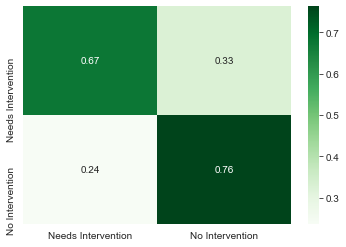

In [9]:
XGBparams = {'n_estimators':[400, 750],
             'max_depth':[4, 7],
             'learning_rate':[.01, .1], 
             'subsample':[.5,.7],
             'min_child_weight':[4,5],
             'num_parallel_tree':[3,4],
             'eval_metric':['logloss'],
            'colsample_bytree':[.7,.8],
            'base_score':[.4,.6]}
           
XBGgrid = GridSearchPresentationCV(XGBClassifier(objective='binary:logistic', 
                                                 eval_metric='logloss',
                                                 n_jobs=-1, random_state=111),
                                 XGBparams, scoring = 'accuracy', verbose = 1)
XBGgrid.fit(train_df)

XGBmodel = score_grid(XBGgrid, X_test_transformed, y_test)

pickle.dump(XGBmodel, open('../models/XGBmodel5.pkl','wb'))

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

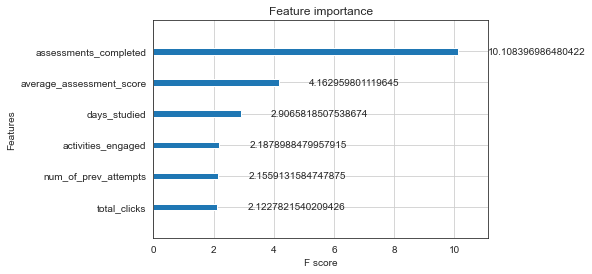

In [10]:
plot_importance(XGBmodel, importance_type = 'gain')

## XGBoost evaluation:
XGBoost gave us the best cross-validated score of these four model types.  While it performs slightly worse on the validation set than the random forest, looking at the scores across folds, it seems likely that this represents the validation set being a sort of bad split.  XGBoost also performs equally well on both classes.  It correctly identifies 74% of students who need intervention to succeed, while misclassifying 27% of passing students as needing intervention.  

## K-Nearest Neighbors
This model positions each observation (student registration in this case) from the training set in n_feature dimensional space.  New observations from the test set are voted on by the closest K observations from the training set to determine which class the new observation should belong to. There are two big benefits to this modeling technique for our dataset.  The first is that it is fast with few features.  We have only 6 features, so the dimensionality of the space is low, observations are more tightly packed, and the model makes determinations quickly.  The second benefit is that it is non-linear.  We've had some success with more linear models, and decision tree models.  Our error analysis and EDA show that there are strong linear relationships between our variables and the success of students.  However there is a solid 20% of students that cannot seem to be classified with these linear models.  The decision tree models similar seem to fail to classify these students.  Perhaps this model can help find where they belong.  

trying:
{'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
average score:  0.7816229206391514
trying:
{'n_neighbors': 30, 'p': 1, 'weights': 'uniform'}
average score:  0.778327931945943
trying:
{'n_neighbors': 30, 'p': 2, 'weights': 'distance'}
average score:  0.7762959415246026
trying:
{'n_neighbors': 30, 'p': 2, 'weights': 'uniform'}
average score:  0.7719678749220049
trying:
{'n_neighbors': 30, 'p': 5, 'weights': 'distance'}
average score:  0.7747108642615654
trying:
{'n_neighbors': 30, 'p': 5, 'weights': 'uniform'}
average score:  0.770707597136573
trying:
{'n_neighbors': 30, 'p': 10, 'weights': 'distance'}
average score:  0.7750844329794376
trying:
{'n_neighbors': 30, 'p': 10, 'weights': 'uniform'}
average score:  0.7699881152398784
trying:
{'n_neighbors': 30, 'p': 15, 'weights': 'distance'}
average score:  0.7747390801193396
trying:
{'n_neighbors': 30, 'p': 15, 'weights': 'uniform'}
average score:  0.7710839909811718
trying:
{'n_neighbors': 30, 'p': 20, 'weights': 'distance'}
ave

score
code_module code_presentation          
AAA         2013J                   NaN
BBB         2013B              0.804842
            2013J              0.785247
            2014B              0.811177
CCC         2014B                   NaN
DDD         2013B              0.772967
            2013J              0.789511
            2014B              0.820331
EEE         2013J              0.757946
            2014B              0.828729
FFF         2013B               0.78554
            2013J              0.786355
            2014B              0.794756
GGG         2013J               0.70452
            2014B              0.797158

cross validated accuracy score:
0.7876216084242276
validation accuracy: 
0.7407313997477932
validation set confusion matrix


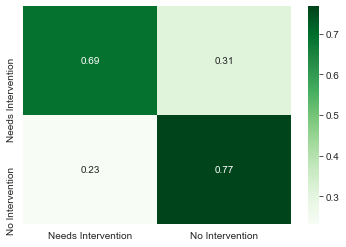

In [11]:
KNNparams = {'n_neighbors':[30, 50, 100, 150, 200, 300],
            'weights':['distance', 'uniform'],
             'p':[1,2,5,10,15,20]}
             
KNNgrid = GridSearchPresentationCV(KNeighborsClassifier(n_jobs = -1), KNNparams, 
                                scoring='accuracy', verbose = 1)

KNNgrid.fit(train_df)
KNNmodel = score_grid(KNNgrid, X_test_transformed, y_test)
pickle.dump(KNNmodel, open('../models/KNNmodel2.pkl','wb'))

### KNN Evaluation
This model, like the others, seems to top out around 77%.  We still haven't found a way to capture the pattern for how those last 20-23% of students fail or withdraw.  Looking at our error analysis from the final report notebook we see that those misclassfied students really look a lot like successful ones according to all of our variables.  It may just be that we don't have the right variable to find the connection.  We may be running up against the irreducible error for this feature set.

                    precision    recall  f1-score   support

Needs Intervention       0.61      0.68      0.64      2735
   No Intervention       0.82      0.77      0.80      5195

          accuracy                           0.74      7930
         macro avg       0.72      0.73      0.72      7930
      weighted avg       0.75      0.74      0.74      7930



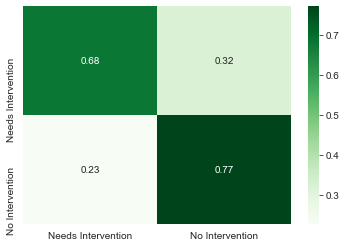

In [12]:
LRmodel.fit(X_train_transformed,y_train_transformed)
y_pred = LRmodel.predict(X_test_transformed)
plot_confusion(y_test, y_pred)
print(classification_report(y_test,y_pred))

                    precision    recall  f1-score   support

Needs Intervention       0.58      0.71      0.64      2735
   No Intervention       0.83      0.73      0.78      5195

          accuracy                           0.73      7930
         macro avg       0.71      0.72      0.71      7930
      weighted avg       0.74      0.73      0.73      7930



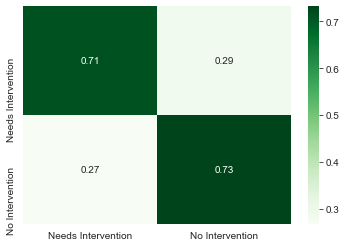

In [13]:
DTmodel.fit(X_train_transformed,y_train_transformed)
y_pred = DTmodel.predict(X_test_transformed)
plot_confusion(y_test, y_pred)
print(classification_report(y_test,y_pred))

                    precision    recall  f1-score   support

Needs Intervention       0.58      0.74      0.65      2735
   No Intervention       0.84      0.72      0.78      5195

          accuracy                           0.73      7930
         macro avg       0.71      0.73      0.72      7930
      weighted avg       0.75      0.73      0.73      7930



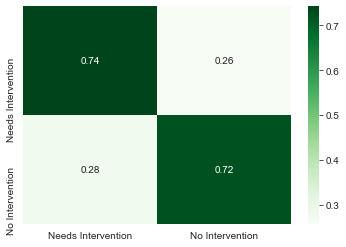

In [14]:
RFmodel.fit(X_train_transformed,y_train_transformed)
y_pred = RFmodel.predict(X_test_transformed)
plot_confusion(y_test, y_pred)
print(classification_report(y_test,y_pred))

                    precision    recall  f1-score   support

Needs Intervention       0.61      0.66      0.64      2735
   No Intervention       0.81      0.78      0.80      5195

          accuracy                           0.74      7930
         macro avg       0.71      0.72      0.72      7930
      weighted avg       0.75      0.74      0.74      7930



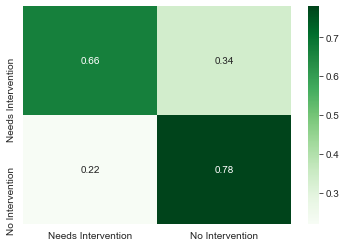

In [15]:
XGBmodel.fit(X_train_transformed,y_train_transformed)
y_pred = XGBmodel.predict(X_test_transformed)
plot_confusion(y_test, y_pred)
print(classification_report(y_test,y_pred))

                    precision    recall  f1-score   support

Needs Intervention       0.61      0.69      0.65      2735
   No Intervention       0.82      0.77      0.79      5195

          accuracy                           0.74      7930
         macro avg       0.72      0.73      0.72      7930
      weighted avg       0.75      0.74      0.74      7930



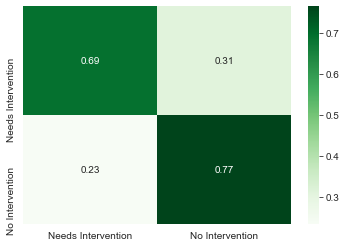

In [16]:
KNNmodel.fit(X_train_transformed,y_train_transformed)
y_pred = KNNmodel.predict(X_test_transformed)
plot_confusion(y_test, y_pred)
print(classification_report(y_test,y_pred))

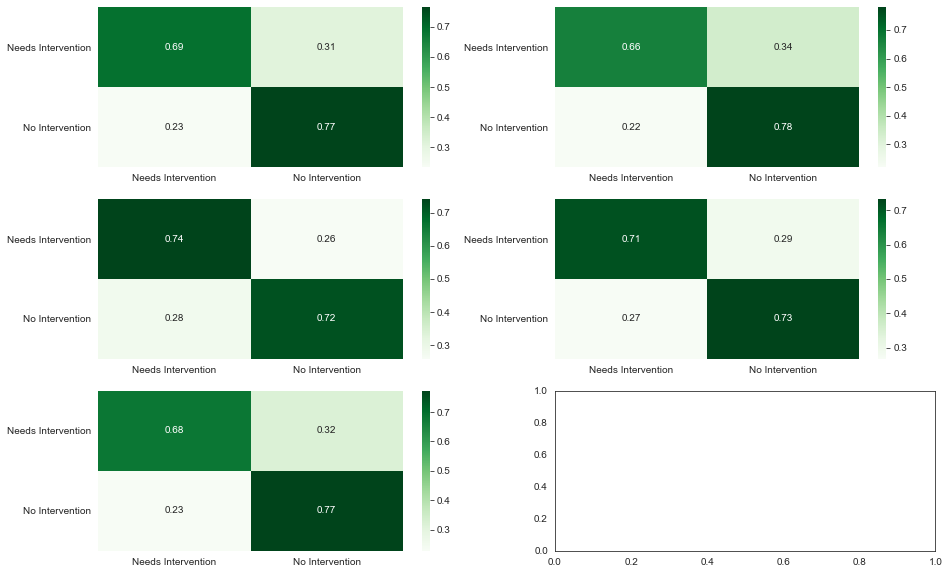

In [17]:
fig, axes = plt.subplots(3,2, figsize=(15,10))
axes = axes.ravel()
models = [KNNmodel, XGBmodel, RFmodel, DTmodel, LRmodel]
for i, model in enumerate(models):
    y_pred = model.predict(X_test_transformed)
    plot_confusion(y_test, y_pred, ax=axes[i])
plt.show()

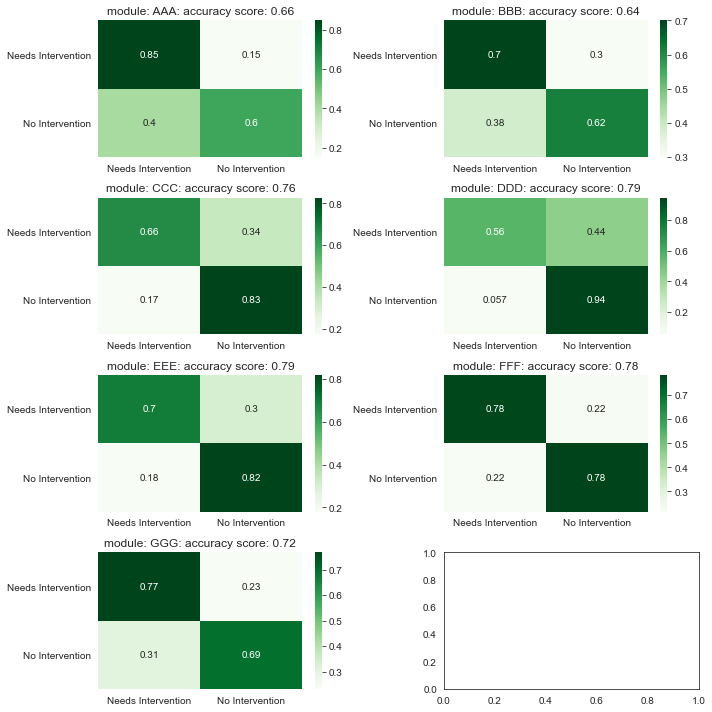

In [18]:
best_model = pickle.load(open('../models/KNNmodel2.pkl','rb'))
best_model.fit(X_train_transformed,y_train_transformed)
y_pred = best_model.predict(X_test_transformed)
eval_df = test_df
eval_df['prediction'] = y_pred
modules = eval_df['code_module'].unique()
course_acc = pd.DataFrame(columns = ['score'],index = modules)
fig, axes = plt.subplots(4,2, figsize = (10,10))
axes = axes.ravel()
for i, module in enumerate(modules):
    preds = eval_df[eval_df['code_module'] == module]['prediction']
    trues = eval_df[eval_df['code_module'] == module]['final_result']
    accuracy = accuracy_score(trues,preds)
    course_acc.loc[module,'score'] = accuracy
    plot_confusion(trues,preds, ax = axes[i])
    axes[i].set_title(f'module: {module}: accuracy score: {round(accuracy,2)}')
plt.tight_layout()
plt.savefig('../figures/KNNmodel2accbymodule.png')
plt.show()